In [1]:
from shapely.geometry import Point, Polygon
from shapely.plotting import patch_from_polygon
import matplotlib.pyplot as plt
import math 
import random
from src.core.polygon_utils import box_to_coords, sample_from_polygon, check_if_polygons_overlap, inflate_polygon, inflate_circle

In [58]:
def add_random_table(room_coords, other_tables_coords, min_distance_between_tables, table_size=None, rotation_angle=None, max_iter = 50000):
    ''' 
    :param room_coords: list of tuples (x,y) shape:(4,2) representing the coordinates of the room
    :param table_size: string representing the size ("small", "medium", "large") of the table or two numbers representing width and length of the table
    :return: list of tuples (x,y) shape:(4,2) representing the coordinates of the table
    '''
    # handle parameter table_size
    i = 0
    while True and i < max_iter:
        i += 1
        table_coords = generate_random_table_coords(room_coords, table_size, rotation_angle)
        if check_if_table_is_valid(room_coords, table_coords, other_tables_coords, min_distance_between_tables): 
            return table_coords


def generate_random_table_coords(room_coords, table_size = None, rotation_angle = None):
    # 1. Handle input
    # if table_size == None: table_size = (random.randint(4,10), random.randint(2,5))
    if table_size == None: table_size = (random.randint(7,10), random.randint(4,7))
    elif table_size == 'small': table_size = (1,2)
    elif table_size == 'medium': table_size = (1,3)
    elif table_size == 'large': table_size = (2,4)
    elif isinstance (table_size, (tuple, list)) and len(table_size) == 2: pass
    else : raise ValueError('table_size must be "small", "medium", "large" or a tuple of two numbers')

    if rotation_angle == None: rotation_angle = random.randint(0,360)
    elif isinstance(rotation_angle, (float, int)): pass
    else : raise ValueError('rotation_angle must be an integer')
    rotation_angle = math.radians(rotation_angle) # transfer to radians

    # 2. Generate random origin point
    origin_coords = sample_from_polygon(room_coords)
    # 3. generate random coordinates for the table
    table_coords = box_to_coords(table_size, origin_coords, rotation_angle)
    return table_coords


def check_if_table_is_valid(room_coords, table_coords, other_tables_coords, min_distance_between_tables):
    # check if the table is inside the room
    if not Polygon(room_coords).contains(Polygon(table_coords)): return False
    # check if table is not overlapping (or too close) to other tables
    for other_table_coords in other_tables_coords:
        if check_if_polygons_overlap(Polygon(table_coords), Polygon(other_table_coords)): return False # this line probs unnecessary
        if check_if_polygons_overlap(inflate_polygon(Polygon(table_coords), min_distance_between_tables), Polygon(other_table_coords)): return False
    return True


def plot(room_coord, tables_coord, objects_coord):
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    patch = patch_from_polygon(Polygon(room_coord), facecolor=[0,0,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
    ax.add_patch(patch)
    for table_coord in tables_coord:
        patch = patch_from_polygon(Polygon(table_coord), facecolor=[0,1,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
        ax.add_patch(patch)

    for object_coord in objects_coord:
        patch = patch_from_polygon(Polygon(object_coord), facecolor=[0,0,1], edgecolor=[0,0,0], alpha=0.5, zorder=2)
        ax.add_patch(patch)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    plt.show()

In [59]:
def add_random_object(table_coords, other_objects_coords, min_distance_between_objects, object_size=None, max_iter = 1000):
    ''' 
    :param room_coords: list of tuples (x,y) shape:(4,2) representing the coordinates of the room
    :param table_size: string representing the size of the table or two numbers representing width and length of the table
    :return: list of tuples (x,y) shape:(4,2) representing the coordinates of the table
    '''
    # handle parameter table_size
    i = 0
    if object_size == None: # eg random object size
        while True and i < max_iter:
            i += 1
            object_coords = generate_random_object_coords(table_coords, other_objects_coords, min_distance_between_objects, object_size)
            if object_coords != False: # not False
                return object_coords
        # print("Failed to generate an object!") # triggers if no object was generated
    
    else :
        object_coords = generate_random_object_coords(table_coords, other_objects_coords, min_distance_between_objects, object_size)
        if object_coords != False: # not False
            return object_coords
        # print("Failed to generate an object!")

def generate_random_object_coords(table_coords, other_objects_coords, min_distance_between_objects, object_size = None):
    # 1. Handle input
    # if object_size == None: object_size = random.random() * 2 + 0.5
    if object_size == None: object_size = random.random() * 1 + 0.5
    elif object_size == 'small': object_size = 1
    elif object_size == 'medium': object_size = 2
    elif object_size == 'large': object_size = 3
    elif isinstance (object_size, (int, float)) : pass 
    else : raise ValueError('object_size must be "small", "medium", "large" or a number')


    # 2. Get the space of a table that is not occupied by other objects, increasing each of existing objects by the (min_distance_between_objects+ object_size) value
    free_space = Polygon(table_coords)
    # 2.1 Reduce table polygon by "object_size" distance on the edges of it
    # 2.1.1 - remove radius from height and width
    free_space = free_space.buffer(-object_size)
    # 2.1.2 - add 4 circles on the corners of the table and remove them from the area as well
    corner_circles_ = [Point(table_coords[i]).buffer(object_size) for i in range(4)]
    for circle in corner_circles_:
        free_space = free_space.difference(circle)
    # 2.2 Increase of all the object sizes by the (min_distance_between_objects + object_size) value
    other_objects_coords_ = [inflate_circle(object_coords, min_distance_between_objects + object_size) for object_coords in other_objects_coords]
    # 2.3 Get the space of a table that is not occupied by other objects
    for object in other_objects_coords_:
        free_space = free_space.difference(object)


    # # plot free space
    # fig = plt.figure(1, figsize=(5,5), dpi=90)
    # ax = fig.add_subplot(111)
    # patch = patch_from_polygon(free_space, facecolor=[0,0,0], edgecolor=[0,0,0], alpha=0.5, zorder=2)
    # ax.add_patch(patch)
    # ax.set_xlim(-20, 20)
    # ax.set_ylim(-20, 20)
    # plt.show()

    # 3. generate random coordinates for the table
    try:
        origin_coords = sample_from_polygon(free_space)
    except:
        return False
    object_size = round(object_size, 1)
    object = Point(origin_coords).buffer(object_size)
    return object

# def check_if_object_is_valid(table_coords, object_coords, other_objects_coords, min_distance_between_objects):
#     # check if the table is inside the room
#     if not Polygon(table_coords).contains(object_coords): return False
#     # check if table is not overlapping (or too close) to other tables
#     for other_object_coords in other_objects_coords:
#         if check_if_polygons_overlap(Polygon(object_coords), Polygon(other_object_coords)): return False # this line probs unnecessary
#         if check_if_polygons_overlap(inflate_circle(object_coords, min_distance_between_objects), other_object_coords): return False
#     return True

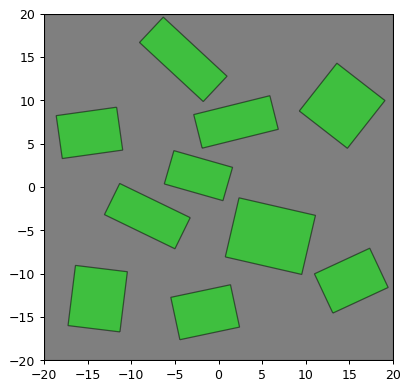

In [60]:
room_coords = [(-20, -20), (-20, 20), (20, 20), (20, -20)]
tables = []
for i in range(10):
    table_coords = add_random_table(room_coords, tables, 1)
    tables.append(table_coords)
plot(room_coords, tables, [])

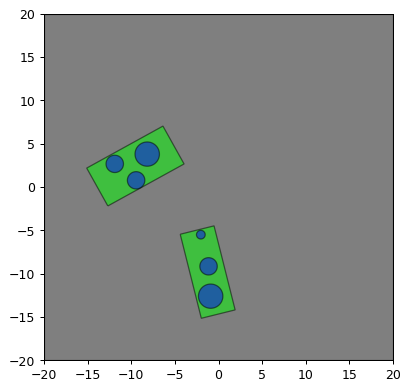

In [72]:
def flatten_2dlist(l): return [item for sublist in l for item in sublist]

room_coords = [(-20, -20), (-20, 20), (20, 20), (20, -20)]
tables = []
for i in range(2):
    table_coords = add_random_table(room_coords, tables, 1)
    tables.append(table_coords)

objects2d = []
for table_coords in tables:
    objects_1d = []
    for i in range(3):
        object_coords = add_random_object(table_coords, objects_1d, min_distance_between_objects = 0.1)
        objects_1d.append(object_coords)
    objects2d.append(objects_1d)

objects = flatten_2dlist(objects2d)
plot(room_coords, tables, objects)

In [73]:
def get_size_of_a_circle(object_circle):
    # return round(object_circle.area ** 0.5,3)
    # return 1
    return round(math.sqrt(object_circle.area / math.pi),3)


def rearrange_objects(objects, tables):
    MAX_ITER = 100000
    successful, i = False, 0
    while not successful and i < MAX_ITER:
        i += 1
        rearranged_objects = rearrange_objects_(objects, tables)
        if rearranged_objects!=False : successful = True
    return rearranged_objects



def rearrange_objects_(objects, tables):
    objects_ = objects.copy()
    tables_ = tables.copy()

    # 1. get size of objects
    # 2. Decide on how many elements should be in each table (randomly)
    # 2.1 Sample N (nr_tables) random numbers, get pct of each number (comparing to entire sum)
    random_nrs = [random.random() for _ in range(len(tables_))]
    pct_per_table = [nr / sum(random_nrs) for nr in random_nrs]
    nr_objects_per_table = [math.ceil(pct * len(objects_)) for pct in pct_per_table]

    # 3. Split objects into tables
    # 3.1 Shuffle objects
    random.shuffle(objects_)
    objects_per_table = []
    for nr_objects in nr_objects_per_table:
        objects_per_table.append(objects_[:nr_objects])
        objects_ = objects_[nr_objects:]
    return randomly_rearrange_objects(objects_per_table, tables)
    # return objects_per_table


def randomly_rearrange_objects(objects_per_table, tables):
    objects2d = []
    for index, table_coords in enumerate(tables):
        objects_1d = []
        for iter2, object in enumerate(objects_per_table[index]):
            # print("iter1:", index, "iter2:", iter2)
            # size = get_size_of_a_circle(object)
            # print("object size:", size)
            try:
                object_coords = add_random_object(table_coords, objects_1d, min_distance_between_objects = 0.1, object_size=get_size_of_a_circle(object))
            except:
                return False
            if object_coords == None:
                return False
            objects_1d.append(object_coords)
        objects2d.append(objects_1d)

    return flatten_2dlist(objects2d)

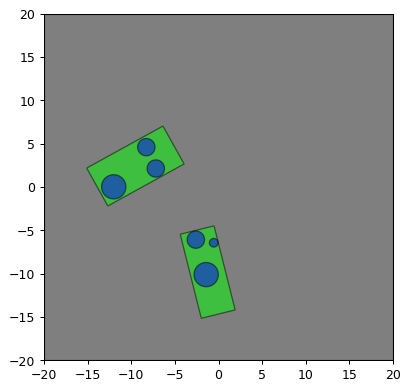

In [74]:
rearranged_objects = rearrange_objects(objects, tables)
plot(room_coords, tables, rearranged_objects)